In [2]:
import os
import numpy as np
import h5py

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# load test results
test_result_root_dir = '/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out'

In [4]:
def out_name(n_win_size=1000, epochs=50, batch=512, 
             learn_rate=0.001, drop=0.1,
             fc_size=32, blocks='4_4_1', cw='221'):
    str_blocks = [str(x) for x in blocks.split('_')]
    str_blk = ''.join(str_blocks)
    return 'b{0}_e{1}_lr{2:.3f}_dr{3:.1f}_fc{4}_blk{5}_win{6}_cw{7}'.format(
            batch, epochs, learn_rate, drop, fc_size, str_blk, n_win_size, cw)

In [5]:
win_size = 1000
model_params = {'n_win_size': win_size,
                    'epochs': 50,
                    'batch': 512,
                    'learn_rate': 0.001,
                    'drop': 0.1,
                    'fc_size': 32,
                    'blocks': '4_4_1',
               'cw':'221'}
test_res_fn = out_name(**model_params)
print(test_res_fn)

b512_e50_lr0.001_dr0.1_fc32_blk441_win1000_cw221


In [8]:
# load the test results using the model trained by 1:1:1 training dataset
test_res_dir = os.path.join(test_result_root_dir, 'model111/test_out')
test_res_fname = os.path.join(test_res_dir, test_res_fn+'-offline-test.h5')

In [9]:
with h5py.File(test_res_fname, 'r') as test_out:
    ypred = test_out.get('ypred').value
    ytrue = test_out.get('ytrue').value

In [10]:
ypred_l = np.argmax(ypred, axis=1)

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from pandas_ml import ConfusionMatrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [12]:
len(ytrue)

5268869

Confusion matrix, without normalization
[[4376224   14216    5664]
 [     45  266509    2650]
 [      8    7928  595625]]


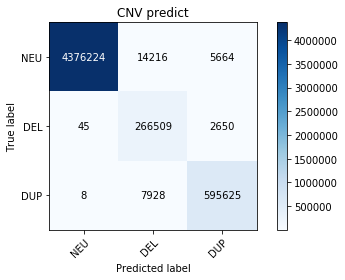

In [13]:
class_names=np.array(['NEU','DEL','DUP'])
plot_confusion_matrix(ytrue, ypred_l[:len(ytrue)], classes=class_names, normalize=False,title='CNV predict')


In [14]:
#  calculate 
def get_cls_reports(y_true,y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    
    # Precision or positive predictive value
    PPV = TP/(TP+FP)

    # Negative predictive value
    NPV = TN/(TN+FN)

    # Fall out or false positive rate
    FPR = FP/(FP+TN)

    # False negative rate or Miss Rate
    FNR = FN/(TP+FN)
    
    # False discovery rate
    FDR = FP/(TP+FP)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return (TPR, TNR, PPV,NPV,FPR,FNR,FDR,ACC)

In [15]:
print(get_cls_reports(ytrue, ypred_l[:len(ytrue)]))

(array([0.99547781, 0.989989  , 0.98685137]), array([0.99993927, 0.9955709 , 0.99821791]), array([0.99998789, 0.92328505, 0.98623371]), array([0.97772779, 0.99945886, 0.9982988 ]), array([6.07265415e-05, 4.42909675e-03, 1.78209027e-03]), array([0.00452219, 0.010011  , 0.01314863]), array([1.21107508e-05, 7.67149484e-02, 1.37662910e-02]), array([0.99621684, 0.99528571, 0.99691585]))


In [16]:
from pycm import ConfusionMatrix
confusion_matrix1 = ConfusionMatrix(ytrue, ypred_l[:len(ytrue)])
#confusion_matrix.print_stats()
print(confusion_matrix1)

Predict       0             1             2             
Actual
0             4376224       14216         5664          

1             45            266509        2650          

2             8             7928          595625        





Overall Statistics : 

95% CI                                                            (0.99414,0.99427)
ACC Macro                                                         0.99614
AUNP                                                              0.99686
AUNU                                                              0.99434
Bennett S                                                         0.99131
CBA                                                               0.96833
Chi-Squared                                                       9923120.23802
Chi-Squared DF                                                    4
Conditional Entropy                                               0.05385
Cramer V                                                   

In [18]:
y_pred = ypred[:len(ytrue)]

In [29]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(n_values=3,sparse=False)
y_true = enc.fit_transform(ytrue.reshape(-1,1))

In [30]:
y_true[0]

array([0., 1., 0.])

In [32]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

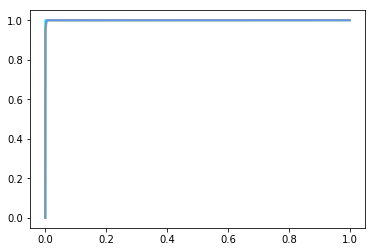

In [34]:
lw = 2
from itertools import cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
thresh = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_true[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
    

Average precision score, micro-averaged over all classes: 1.00


In [41]:
precision[0]

array([0.8347706 , 0.83477057, 0.83477073, ..., 0.99999794, 0.99999904,
       1.        ])

In [42]:
recall[0]

array([1.        , 0.99999977, 0.99999977, ..., 0.55160683, 0.47373265,
       0.        ])

In [43]:
thresh[0]

array([9.9770664e-15, 9.9827771e-15, 9.9830820e-15, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [50]:
neu_prec = precision[0]
np.where(neu_prec>0.99)

(array([782695, 782696, 782697, ..., 948445, 948446, 948447]),)

In [70]:
neu_recall = recall[0]
np.where(neu_recall>0.98)

(array([     0,      1,      2, ..., 910948, 910949, 910950]),)

In [71]:
neu_recall[910950]

0.9800000181979316

In [52]:
neu_thresh = thresh[0]

In [72]:
neu_thresh[910950]

0.99391997

In [66]:
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

In [67]:
precision_recall_threshold(neu_prec, neu_recall, neu_thresh, t=0.8)

NameError: name 'y_scores' is not defined

In [68]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

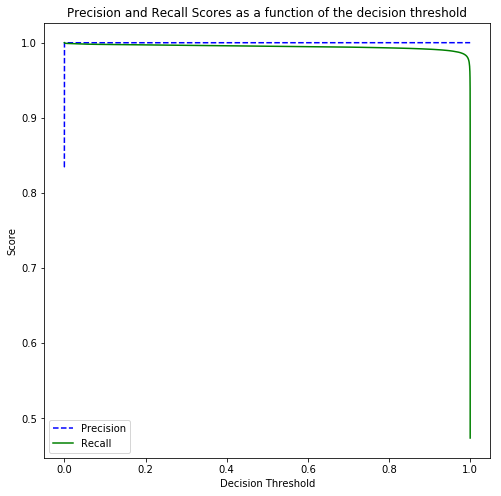

In [69]:
plot_precision_recall_vs_threshold(neu_prec, neu_recall, neu_thresh)

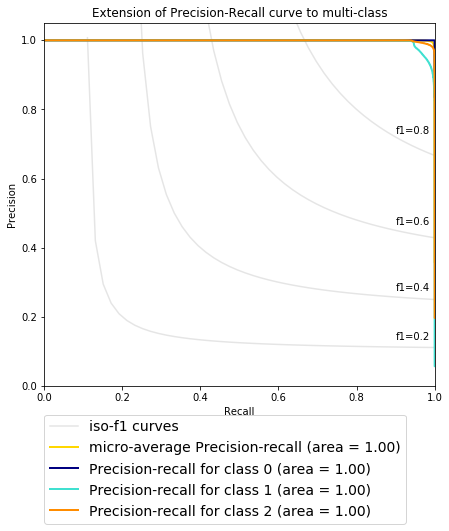

In [39]:
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))
fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))